# Imports

In [1]:
#import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import os
import wfdb
from scipy import signal
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
#from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import neurokit2 as nk
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import layers

# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.expand_frame_repr', False)  # Disable wrapping
# pd.set_option('display.max_colwidth', None)  # Show full contents of each cell

pd.reset_option('display.max_columns')  # Show all columns
pd.reset_option('display.expand_frame_repr')  # Disable wrapping
pd.reset_option('display.max_colwidth')  # Show full contents of each cell


# Load data


In [2]:
# Define the names of the leads to use
leads = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# Initialize empty arrays to store the data and labels
data = []
labels = []

# Specify the root directory
root_dir = 'physionet/classification-of-12-lead-ecgs-the-physionetcomputing-in-cardiology-challenge-2020-1.0.2/training/ptb-xl/'

# Loop over all directories from g1 to g22
for i in range(1, 2): # TODO change to 23
    print(f"analyzing folder {i}/22")

    data_dir = os.path.join(root_dir, f'g{i}')
    record_names = os.listdir(data_dir)
    record_names.sort()
    unique_files = set()

    for file in record_names:
        unique_files.add(os.path.splitext(file)[0])

    # Loop over all records in the directory
    for record_name in unique_files:
        # Remove extension
        filename = os.path.splitext(record_name)[0] 

        # Load the raw ECG signal data from the .dat file
        dat, fields = wfdb.rdsamp(os.path.join(data_dir, filename))
        
        # Load the labels data from the .hea file
        hea = wfdb.rdheader(os.path.join(data_dir, filename))

        # Check if the sampling frequency is 500 Hz
        if hea.fs != 500:
            print(f"Sampling frequency for {filename} is not 500 Hz.")
            continue
        
        labels = hea.comments[2].split(': ')[1].split(',')
        data.append({'record_name': filename, 'label': labels, 'signal': dat})

df = pd.DataFrame(data)
df.to_pickle('df_1000.pkl')
# Load the DataFrame from a pickle file
df = pd.read_pickle('df_1000.pkl')
df


analyzing folder 1/22


,record_name,label,signal
0,HR00655,[426783006],"[[-0.015, -0.05, -0.035, 0.033, 0.01, -0.042, ..."
1,HR00091,[426783006],"[[-0.075, 0.15, 0.225, -0.038, -0.15, 0.187, -..."
2,HR00323,"[164865005, 164917005, 426783006]","[[0.06, 0.08, 0.02, -0.07, 0.02, 0.05, -0.515,..."
3,HR00662,[426783006],"[[-0.085, -0.065, 0.02, 0.075, -0.052, -0.022,..."
4,HR00719,[426783006],"[[-0.035, -0.075, -0.04, 0.055, 0.003, -0.057,..."
...,...,...,...
994,HR00276,"[164934002, 426783006]","[[-0.135, -0.155, -0.02, 0.145, -0.057, -0.087..."
995,HR00643,[426783006],"[[-0.575, -0.52, 0.055, 0.547, -0.315, -0.232,..."
996,HR00170,"[164884008, 39732003, 426783006, 55930002]","[[0.295, -0.095, -0.39, -0.1, 0.343, -0.242, -..."
997,HR00221,[426783006],"[[0.045, -0.025, -0.07, -0.01, 0.058, -0.047, ..."


# Preprocessing

## One Hot

In [3]:
mlb = MultiLabelBinarizer()
mlb.fit(df['label'])
label_encoded = mlb.transform(df['label'])
df_encoded = pd.concat([df.drop('label', axis=1), pd.DataFrame(label_encoded, columns=mlb.classes_)], axis=1)
print(df_encoded.loc[1,'signal']) # liste (un patient) de 5000 listes (samples) à 500hz
print(df_encoded.loc[1,'signal'].shape)

print(df_encoded.shape)
print(len(df_encoded['signal'][0][0]))
print(df_encoded['signal'][0][0])

#df_encoded.to_csv('file.csv', index=False)

[[-0.075  0.15   0.225 ... -0.22  -0.185 -0.16 ]
 [-0.075  0.15   0.225 ... -0.22  -0.185 -0.16 ]
 [-0.075  0.15   0.225 ... -0.22  -0.185 -0.16 ]
 ...
 [-0.005 -0.115 -0.11  ...  0.035  0.015  0.005]
 [-0.005 -0.115 -0.11  ...  0.035  0.015  0.005]
 [-0.005 -0.115 -0.11  ...  0.035  0.015  0.005]]
(5000, 12)
(999, 48)
12
[-0.015 -0.05  -0.035  0.033  0.01  -0.042  0.065  0.455 -0.18  -0.02
 -0.205 -0.07 ]


## Distribution of diseases SNOMED

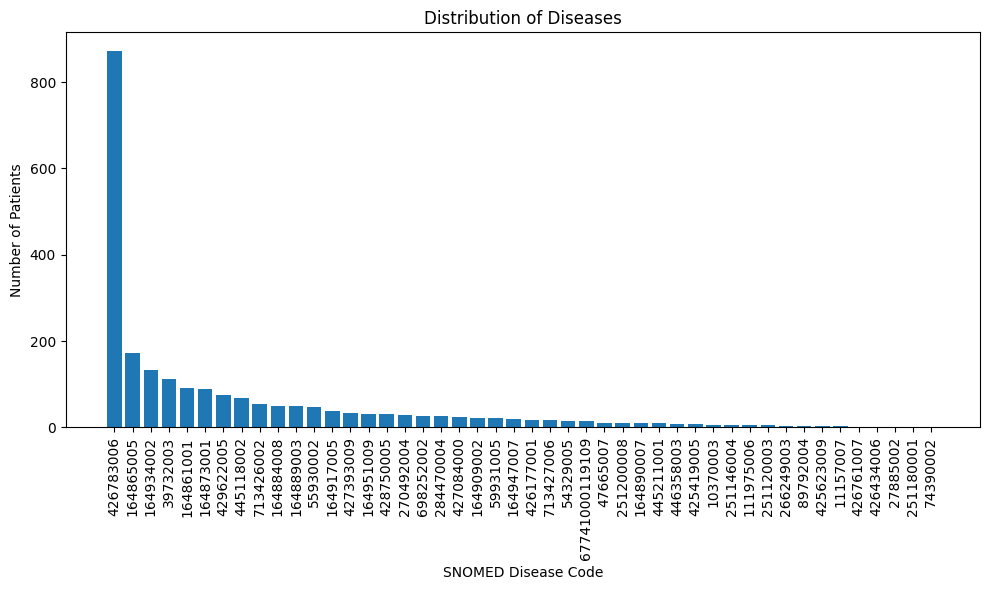

In [4]:
# Dropping non-disease columns
df_diseases = df_encoded.drop(columns=['record_name', 'signal'])

# Count the number of times each disease (where value is 1) appears in the dataset
disease_counts = (df_diseases == 1).sum()

# Sort the disease counts in descending order
disease_counts_sorted = disease_counts.sort_values(ascending=False)

disease_counts_sorted

plt.figure(figsize=(10, 6))

# Bar chart
plt.bar(disease_counts_sorted.index.astype(str), disease_counts_sorted.values)
plt.xlabel('SNOMED Disease Code')
plt.ylabel('Number of Patients')
plt.title('Distribution of Diseases')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## test display

500.0


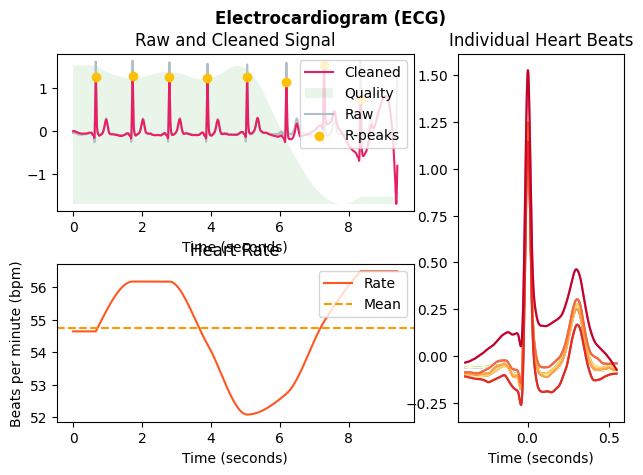

In [5]:
single_ecg = []
for sublist in df_encoded.loc[0,'signal']: #FIRST PATIENT
    single_ecg.append(sublist[1]) # LEAD II 

#inverted_ecg = nk.ecg_invert(flat_list, sampling_rate=500)
signals, info = nk.ecg_process(single_ecg, sampling_rate=500)
rpeaks = info["ECG_R_Peaks"]
#cleaned_ecg = signals["ECG_Clean"]

# Segment the ECG into individual heartbeats using the R-peaks
heartbeats = np.split(single_ecg, rpeaks)

# TODO check accuracy sans enlever le dernier beat
# Check if the last heartbeat is incomplete (i.e., significantly shorter than the others)
average_heartbeat_length = np.mean([len(heartbeat) for heartbeat in heartbeats])
print(average_heartbeat_length)

if len(heartbeats[-1]) < average_heartbeat_length * 0.75:
    heartbeats = heartbeats[:-1]  # Remove the last heartbeat if incomplete

# Concatenate the heartbeats back into a single ECG signal
cleaned_ecg = np.concatenate(heartbeats)
signals, info = nk.ecg_process(cleaned_ecg, sampling_rate=500)

#plot = nk.events_plot(rpeaks, cleaned_ecg) #WHole ecg

#epochs = nk.ecg_segment(cleaned_ecg, rpeaks=None, sampling_rate=500, show=True) # beatss superimposed

#nk.ecg_plot(signals, sampling_rate=500) # summary of ecg
nk.ecg_plot(signals, sampling_rate=500) # summary of ecg
# _, waves_peak = nk.ecg_delineate(signals, # PQRS peaks
#                                  rpeaks, 
#                                  sampling_rate=500, 
#                                  method="peak", 
#                                  show=True, 
#                                  show_type='peaks')


## Remove last beat if incomplete

In [6]:
# def clean_heartbeats(row):
#     all_leads = []
#     for sublist in row['signal']:
#         all_leads.append(sublist)  # Get all leads 

#     # Process lead II to get R-peaks
#     single_ecg_lead_II = [sublist[1] for sublist in row['signal']]  # LEAD II 
#     try:
#         signals, info = nk.ecg_process(single_ecg_lead_II, sampling_rate=500)
#     except ValueError as e:
#         print(f"An error occurred while processing the ECG data for record {row['record_name']}: {e}")
#         return single_ecg_lead_II  # Return the original ECG signal if an error occurs

#     rpeaks = info["ECG_R_Peaks"]
#     # Remove NaN values from rpeaks
#     rpeaks = rpeaks[~np.isnan(rpeaks)]
#     try:
#         heartbeats_II = np.split(single_ecg_lead_II, rpeaks.astype(int))
#     except ValueError as e:
#         print(f"An error occurred while splitting the ECG data for record {row['record_name']}: {e}")
#         return single_ecg_lead_II  # Return the original ECG signal if an error occurs

#     # Check if the last heartbeat is incomplete (i.e., significantly shorter than the others)
#     average_heartbeat_length = np.mean([len(heartbeat) for heartbeat in heartbeats_II])
#     if len(heartbeats_II[-1]) < average_heartbeat_length * 0.75:
#         rpeaks = rpeaks[:-1]  # Remove the last R-peak

#     # Use the R-peaks to segment all leads and remove incomplete heartbeats
#     cleaned_ecg_leads = []
#     for lead in all_leads:
#         try:
#             heartbeats = np.split(lead, rpeaks.astype(int))
#         except ValueError as e:
#             print(f"An error occurred while splitting the ECG data for record {row['record_name']}: {e}")
#             return lead  # Return the original ECG signal if an error occurs

#         if len(heartbeats[-1]) < average_heartbeat_length * 0.75:
#             heartbeats = heartbeats[:-1]  # Remove the last heartbeat if incomplete

#         # Concatenate the heartbeats back into a single ECG signal
#         cleaned_ecg_lead = np.concatenate(heartbeats)
#         cleaned_ecg_leads.append(cleaned_ecg_lead)

#     # Stack the cleaned leads back together
#     cleaned_ecg = np.stack(cleaned_ecg_leads, axis=-1)
#     return cleaned_ecg


# # Apply the function to the 'signal' column of the DataFrame
# df_encoded['signal'] = df_encoded.apply(clean_heartbeats, axis=1)
# print(df_encoded)
# print(df_encoded['signal'][0])
# print(df_encoded['signal'][0][0])
# print(df_encoded['signal'][0][0][0])
# print(df_encoded.shape)


## Noise filtering

## Remove Outliers

In [7]:

# Compute the mean and standard deviation for each record
means = np.array([np.mean(record) for record in df_encoded['signal']])
std_devs = np.array([np.std(record) for record in df_encoded['signal']])

# Compute the average mean and standard deviation
avg_mean = np.mean(means)
avg_std_dev = np.mean(std_devs)

# Compute the standard deviation of the means and standard deviations
std_mean = np.std(means)
std_std_dev = np.std(std_devs)

# Identify outliers as records where the mean or standard deviation
# is more than 3 standard deviations away from the average
outlier_indices = np.where(
    (np.abs(means - avg_mean) > 3 * std_mean) | 
    (np.abs(std_devs - avg_std_dev) > 3 * std_std_dev)
)[0]

# Remove outliers from df
df_cleaned = df_encoded.drop(outlier_indices)
print(df_cleaned.shape)
print(len(df_cleaned['signal'][0]))
print(df_cleaned['signal'][0][0])


(964, 48)
5000
[-0.015 -0.05  -0.035  0.033  0.01  -0.042  0.065  0.455 -0.18  -0.02
 -0.205 -0.07 ]


# Split

In [8]:
X = df_cleaned['signal']
y = df_cleaned.drop(['record_name', 'signal'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

X_train.shape, X_val.shape, X_test.shape




#TODO fine-tune, Bootstrap aggregating (bagging)


((674,), (145,), (145,))

## Normalization 

In [9]:

# #TODO poorly done? does it work? try without?

# # Initialize a scaler
# scaler = MinMaxScaler()

# print(X_train.shape)

# # Fit the scaler to the training data and transform it
# X_train_scaled = [scaler.fit_transform(patient_data) for patient_data in X_train]

# # Transform the validation and test data
# X_val_scaled = [scaler.transform(patient_data) for patient_data in X_val]
# X_test_scaled = [scaler.transform(patient_data) for patient_data in X_test]



# CNN 


In [1]:

# Define the model
model = tf.keras.models.Sequential([
    layers.Input(shape=(5000, 12)),
    layers.Conv1D(64, 7, activation='relu'),
    layers.MaxPooling1D(3),
    layers.Conv1D(64, 7, activation='relu'),
    layers.MaxPooling1D(3),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(y.shape[1], activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Define the model
# model = tf.keras.models.Sequential([
#     layers.Input(shape=(5000, 12)),
#     layers.Conv1D(128, 8, activation='relu'),
#     layers.MaxPooling1D(3),
#     layers.Conv1D(256, 5, activation='relu'),
#     layers.MaxPooling1D(3),
#     layers.Conv1D(128, 3, activation='relu'),
#     layers.MaxPooling1D(3),
#     layers.Dropout(0.5),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(y.shape[1], activation='sigmoid')
# ])

# # Compile the model with the specified learning rate
# #optimizer = Adam(learning_rate=0.00002)
# #model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# # Print the model summary
# model.summary()




NameError: name 'tf' is not defined

In [11]:
print(np.array(X_train.iloc[363]).shape)
print(len(np.array(X_train.iloc[363])))


# Reshape the data
num_samples = len(X_train)  # replace with len(X_val) and len(X_test) for validation and test sets
num_samples_val = len(X_val)  # replace with len(X_val) and len(X_test) for validation and test sets
num_timesteps = 5000  # number of time points in each ECG record
num_channels = 12  # number of leads in each ECG record

# X_train_array = np.array(X_train.tolist())  # Convert Series to numpy array
# X_val_array = np.array(X_val.tolist())  # Convert Series to numpy array

# TODO Transpose if necessary
# X_train_array = [np.array(x).T for x in X_train]
# X_val_array = [np.array(x).T for x in X_val]

# Convert y_train and y_val to numpy arrays
y_train_array = np.array(y_train)
y_val_array = np.array(y_val)

# Here, I'm going to modify the X_train_array and y_train_array by removing entries where the shape of the X is not (5000, 12).
# This will be done in-place without storing the problematic indices first.

print(len(X_train))
X_train_array_clean = []
y_train_array_clean = []

for x, y in zip(X_train, y_train_array):
    if x.shape == (5000, 12):
        
        X_train_array_clean.append(x)
        y_train_array_clean.append(y)

X_train_array = X_train_array_clean
y_train_array = y_train_array_clean

X_val_array_clean = []
y_val_array_clean = []

for x, y in zip(X_val, y_val_array):
    if x.shape == (5000, 12):
        X_val_array_clean.append(x)
        y_val_array_clean.append(y)

X_val_array = X_val_array_clean
y_val_array = y_val_array_clean

# Calculate the maximum sequence length
max_len = max(max(len(x) for x in X_train_array), max(len(x) for x in X_val_array))

def generator(X, y, max_len, num_channels):
    while True:
        for i in range(len(X)):
            seq = X[i]
            # Pad each sequence if necessary
            if seq.shape[0] < max_len:
                seq = np.pad(seq, ((0, max_len - seq.shape[0]), (0, 0)), 'constant')
            
            # Check the shape of the sequence
            if seq.shape != (max_len, num_channels):
                print(f"Sequence at index {i} has shape {seq.shape} instead of {(max_len, num_channels)}")
            
            # Reshape the sequence
            seq = seq.reshape(1, max_len, num_channels)
            
            yield seq, np.array([y[i]])


# Create generators for the training and validation data
train_gen = generator(X_train_array, y_train_array, max_len=max_len, num_channels=12)
val_gen = generator(X_val_array, y_val_array, max_len=max_len, num_channels=12)

# problematic_indices_val = [i for i, x in enumerate(train_gen) if x.shape != (5000, 12)]
# print(len(problematic_indices_val))
# print(f"problemsatic indices :{problematic_indices_val}")
print(train_gen)
# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(X_train_array),
    validation_steps=len(X_val_array),
    epochs=10
)


(5000, 12)
5000
674
<generator object generator at 0x000001BE4DEC4B30>
Epoch 1/10
674/674 [==============================] - 17s 24ms/step - loss: 0.2101 - accuracy: 0.4065 - val_loss: 0.1291 - val_accuracy: 0.4690
Epoch 2/10
674/674 [==============================] - 16s 24ms/step - loss: 0.1473 - accuracy: 0.4955 - val_loss: 0.1274 - val_accuracy: 0.4690
Epoch 3/10
674/674 [==============================] - 16s 24ms/step - loss: 0.1333 - accuracy: 0.5000 - val_loss: 0.1315 - val_accuracy: 0.4690
Epoch 4/10
674/674 [==============================] - 16s 24ms/step - loss: 0.1258 - accuracy: 0.4970 - val_loss: 0.1321 - val_accuracy: 0.4690
Epoch 5/10
674/674 [==============================] - 16s 24ms/step - loss: 0.1169 - accuracy: 0.4970 - val_loss: 0.1373 - val_accuracy: 0.4690
Epoch 6/10
674/674 [==============================] - 16s 24ms/step - loss: 0.1129 - accuracy: 0.5000 - val_loss: 0.1373 - val_accuracy: 0.4690
Epoch 7/10
674/674 [==============================] - 16s 24ms/st

## Test

In [12]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

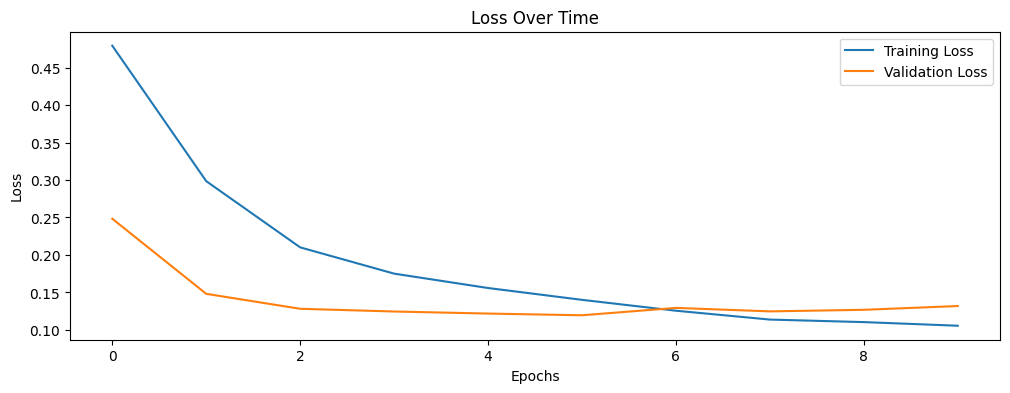

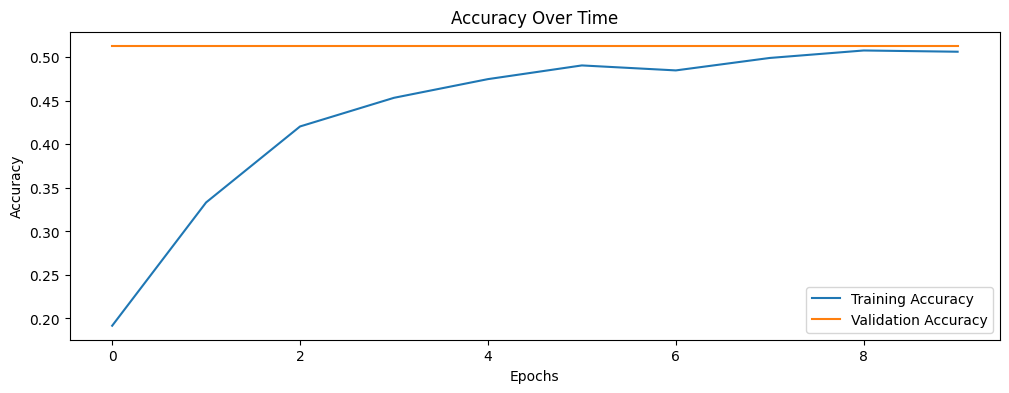

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Time')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(12, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Time')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()


todo: 
 - complete preprocessing -> normalization, Noise Reduction, Outlier Removal,Data Augmentation,downsampling, invert? 
 - convert signal to spectogram 2D? (not 1D CNN raw data anymore, can be generated with STFT, 2D CNN) 1D simpler but 2D may perform better
 - remove diseases because accuracy is poor
 - rajouter age et sexe?
 - CNN prep, build, model train, evaluate
 - RNN
 - Transofrmer

Done:
- remove last beat (when 0 volt)

tests with basic CNN, 1000 premiers:
- no normalize, no removal beat : 
- normalized, removed beat: 0.5
- normalized, no removed beat: 
- no normalized, removed beat: 0.51 (problem in normalization?)

